In [15]:
from sklearn.datasets import fetch_openml

In [16]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

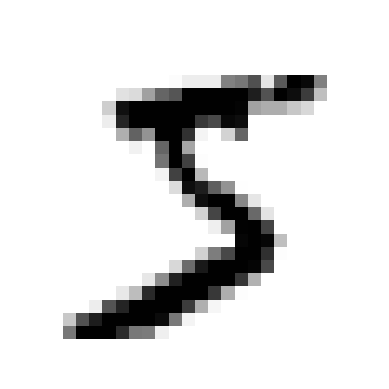

In [18]:
X = mnist["data"]
y = mnist["target"]

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [19]:
y[0]

'5'

In [20]:
y = y.astype(np.uint8)  # label converting: string to int

In [21]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Binary Classifier**<br/>
<i>Five or not five?<i>

In [22]:
y_train_5 = (y_train == 5)  # True for 5, False for remaining
y_test_5 = (y_test == 5)

In [23]:
from sklearn.linear_model import SGDClassifier  # Stochastic Gradient Descent

In [24]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])


array([ True])

**Cross Validation**

In [26]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [27]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [28]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

**Confusion Matrix**

In [30]:
# Predicitons set
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [32]:
# Perfect predictions simulate
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

**Precision & Recall Scores**

In [34]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))  # PP/(PP+FP)
print(recall_score(y_train_5, y_train_pred))  # PP/(PP+FN)

0.8370879772350012
0.6511713705958311


In [35]:
# F1 score - harmonic mean of precision and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

**Precision - Recall compromise**

In [36]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [40]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [41]:
# raising the threshold reduces recall
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

*Selecting the threshold*

In [42]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [43]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

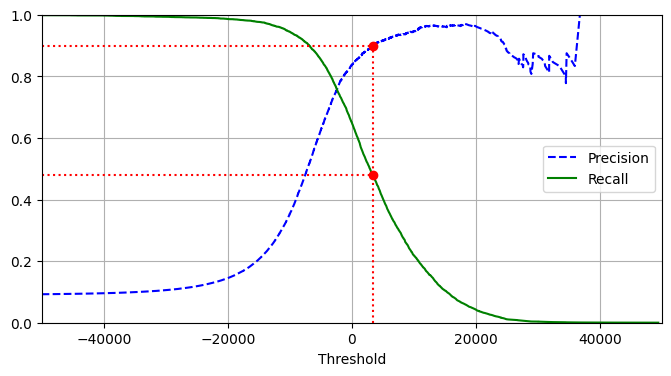

In [55]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right")
    plt.xlabel("Threshold")
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")

plt.show()

In [56]:
y_train_pred_90 = (y_scores > threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9
0.47980077476480354
